# Dynamic ecoregions

## Define inputs

In [1]:
# Inputs
input_file = "data/data-continental-united-states.csv"
geohash_precision = 4
log_file = "run.log"
output_file = "output.geojson"
num_clusters = 8
use_cache = False
plot = True

## Set up logging

In [2]:
import logging

logging.basicConfig(filename=log_file, encoding="utf-8", level=logging.INFO)

## Data flow

```mermaid
flowchart
    DarwinCoreCsvLazyFrame --> TaxonomyDataFrame
    DarwinCoreCsvLazyFrame --> GeohashSpeciesCountsDataFrame
    GeohashSpeciesCountsDataFrame --> DistanceMatrix
    GeohashSpeciesCountsDataFrame --> GeohashClusterDataFrame
    DistanceMatrix --> GeohashClusterDataFrame
    GeohashClusterDataFrame --> ClusterColorDataFrame
    GeohashSpeciesCountsDataFrame --> ClusterTaxaStatisticsDataFrame
    GeohashClusterDataFrame --> ClusterTaxaStatisticsDataFrame
    TaxonomyDataFrame --> ClusterTaxaStatisticsDataFrame
```

## `DarwinCoreCsvLazyFrame`

### Build

In [3]:
from src.lazyframes.darwin_core_csv import DarwinCoreCsvLazyFrame

darwin_core_csv_lazy_frame = DarwinCoreCsvLazyFrame.from_file(input_file)

### Preview

In [4]:
darwin_core_csv_lazy_frame.lf.limit(3).collect()

gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,infraspecificEpithet,taxonRank,scientificName,verbatimScientificName,verbatimScientificNameAuthorship,countryCode,locality,stateProvince,occurrenceStatus,individualCount,publishingOrgKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation,elevationAccuracy,depth,depthAccuracy,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
str,str,str,enum,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str,u64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""4424226317""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Odonata""","""Libellulidae""","""Sympetrum""",null,null,"""GENUS""","""Sympetrum Newman, 1833""","""Sympetrum""",null,"""US""",null,"""New York""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",42.96266,-76.740947,"""2191.0""",null,null,null,null,null,"""2019-09-06T10:30""","""6""","""9""","""2019""",1428195,null,"""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32505913""",null,"""Amy Guala""","""2019-09-11T01:33:07""","""CC_BY_NC_4_0""","""Amy Guala""","""Amy Guala""",null,null,"""2024-12-03T00:52:33.467Z""","""StillImage""","""COORDINATE_ROUNDED;CONTINENT_D…"
"""2423028148""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Lepidoptera""","""Geometridae""","""Nematocampa""","""Nematocampa resistaria""",null,"""SPECIES""","""Nematocampa resistaria (Herric…","""Nematocampa resistaria""",null,"""US""",null,"""Vermont""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",43.822608,-72.641412,"""5.0""",null,null,null,null,null,"""2019-09-11T22:08:52""","""11""","""9""","""2019""",1991012,"""1991012""","""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32566956""",null,"""bugguytad""","""2019-09-12T02:25:38""","""CC_BY_NC_4_0""","""bugguytad""","""bugguytad""",null,null,"""2024-12-03T01:38:46.617Z""","""StillImage;StillImage;StillIma…","""COORDINATE_ROUNDED;CONTINENT_D…"
"""2423041120""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Odonata""","""Coenagrionidae""","""Argia""","""Argia moesta""",null,"""SPECIES""","""Argia moesta (Hagen, 1861)""","""Argia moesta""",null,"""US""",null,"""Texas""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",30.99463,-103.662658,null,null,null,null,null,null,"""2019-09-08T09:01""","""8""","""9""","""2019""",5051399,"""5051399""","""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32612673""",null,"""Todd Fitzgerald""","""2019-09-12T22:11:30""","""CC_BY_NC_4_0""","""Todd Fitzgerald""","""Todd Fitzgerald""",null,null,"""2024-12-03T01:38:10.816Z""","""StillImage""","""COORDINATE_ROUNDED;CONTINENT_D…"


## `TaxonomyDataFrame`

### Build

In [5]:
from src.dataframes.taxonomy import TaxonomyDataFrame

taxonomy_dataframe = TaxonomyDataFrame.build(darwin_core_csv_lazy_frame)

### Preview

In [6]:
taxonomy_dataframe.df.limit(3)

kingdom,phylum,class,order,family,genus,species
enum,str,str,str,str,str,str
"""Chromista""","""Ciliophora""","""Gymnostomatea""","""Pleurostomatida""","""Amphileptidae""","""Kentrophyllum""","""Kentrophyllum verrucosum"""
"""Plantae""","""Tracheophyta""","""Magnoliopsida""","""Ericales""","""Ericaceae""","""Vaccinium""","""Vaccinium hirsutum"""
"""Animalia""","""Chordata""",null,"""Scorpaeniformes""","""Cottidae""","""Artediellus""","""Artediellus uncinatus"""


## `GeohashSpeciesCountsDataFrame`

### Build

In [7]:
from src.dataframes.geohash_species_counts import GeohashSpeciesCountsDataFrame

geohash_taxa_counts_dataframe = GeohashSpeciesCountsDataFrame.build(
    darwin_core_csv_lazy_frame, geohash_precision
)

### Preview

In [8]:
geohash_taxa_counts_dataframe.df.limit(3)

geohash,kingdom,rank,name,count
str,enum,enum,str,u32
"""97zz""","""Animalia""","""species""","""Eschrichtius robustus""",1
"""9eb4""","""Animalia""","""species""","""Papilio rutulus""",1
"""9ebn""","""Animalia""","""species""","""Eschrichtius robustus""",1


## `DistanceMatrix`

### Build

In [9]:
from src.distance_matrix import DistanceMatrix

distance_matrix = DistanceMatrix.build(
    geohash_taxa_counts_dataframe,
    use_cache,
)

### Preview

In [10]:
distance_matrix.squareform()

array([[0.        , 0.09040011, 0.        , ..., 0.06185817, 0.14372581,
        0.14044274],
       [0.09040011, 0.        , 0.09040011, ..., 0.06174325, 0.13844873,
        0.13469881],
       [0.        , 0.09040011, 0.        , ..., 0.06185817, 0.14372581,
        0.14044274],
       ...,
       [0.06185817, 0.06174325, 0.06185817, ..., 0.        , 0.12402949,
        0.1219072 ],
       [0.14372581, 0.13844873, 0.14372581, ..., 0.12402949, 0.        ,
        0.170798  ],
       [0.14044274, 0.13469881, 0.14044274, ..., 0.1219072 , 0.170798  ,
        0.        ]], shape=(20751, 20751))

## `GeohashClusterDataFrame`

### Build

In [11]:
from src.dataframes.geohash_cluster import GeohashClusterDataFrame

geohash_cluster_dataframe = GeohashClusterDataFrame.build(
    geohash_taxa_counts_dataframe,
    distance_matrix,
    num_clusters,
)

### Preview

In [12]:
geohash_cluster_dataframe.df.limit(3)

geohash,cluster
str,u32
"""97zz""",6
"""9eb4""",6
"""9ebn""",6


## `ClusterColorDataFrame`

### Build

In [71]:
from src.dataframes.cluster_color import ClusterColorDataFrame

cluster_colors_dataframe = ClusterColorDataFrame.from_clusters(geohash_cluster_dataframe)

NameError: name 'geohash_cluster_dataframe2' is not defined

### Preview

In [14]:
cluster_colors_dataframe.df.limit(3)

cluster,color
u32,str
1,"""#d8424d"""
2,"""#f57948"""
3,"""#fdbe6e"""


## `ClusterTaxaStatisticsDataFrame`

### Build

In [15]:
from src.dataframes.cluster_taxa_statistics import ClusterTaxaStatisticsDataFrame

cluster_taxa_statistics_dataframe = ClusterTaxaStatisticsDataFrame.build(
    geohash_taxa_counts_dataframe,
    geohash_cluster_dataframe,
    taxonomy_dataframe,
)

### Preview

In [16]:
cluster_taxa_statistics_dataframe.df.limit(3)

cluster,kingdom,rank,name,count,average
u32,enum,enum,str,u32,f64
null,"""Viruses""","""phylum""","""Negarnaviricota""",1360,0.000027
null,"""Animalia""","""phylum""","""Xenacoelomorpha""",16,3.1698e-7
null,"""Animalia""","""phylum""","""Mollusca""",630685,0.012494


## `ClusterSignificantDifferencesDataFrame`

### Build

In [17]:
from src.dataframes.cluster_significant_differences import ClusterSignificantDifferencesDataFrame

cluster_significant_differences_dataframe = ClusterSignificantDifferencesDataFrame.build(
    cluster_taxa_statistics_dataframe,
)

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/src/dataframes/cluster_significant_differences.py:33: UserWarning: Comparisons with None always result in null. Consider using `.is_null()` or `.is_not_null()`.
  pl.col("cluster") == cluster,


### Preview

In [18]:
cluster_significant_differences_dataframe.df.limit(3)

cluster,taxon,percentage_difference
u32,str,f64
1,"""Pinus ponderosa""",2461.858474
1,"""Odocoileus hemionus""",189.361241
1,"""Haliaeetus leucocephalus""",127.04122


## Build and plot GeoJSON feature collection

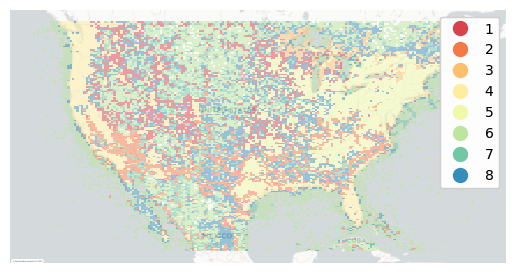

In [24]:
from src.geojson import build_geojson_feature_collection, write_geojson
from src.render import plot_clusters

feature_collection = build_geojson_feature_collection(
    geohash_cluster_dataframe,
    cluster_colors_dataframe,
)

# print_results(darwin_core_aggregations, all_stats, cluster_dataframe)

write_geojson(feature_collection, output_file)

plot_clusters(feature_collection)

write_geojson(feature_collection, output_file)

# Build and display HTML output

In [20]:
from src.html_output import build_html_output
from IPython.display import display, HTML

html = build_html_output(
    cluster_colors_dataframe,
    cluster_significant_differences_dataframe,
)

display(HTML(html))


# TMP START

In [47]:
ordered_geohashes = geohash_taxa_counts_dataframe.ordered_geohashes()

ordered_geohashes

import geohashr
import numpy as np

# Step 1: Create a dictionary mapping each geohash to its neighbors
geo_list = ordered_geohashes
geohash_neighbors = {gh: set(geohashr.neighbors(gh).values()) for gh in geo_list}

# Step 2: Construct a connectivity matrix
num_geohashes = len(geo_list)
connectivity_matrix = np.zeros((num_geohashes, num_geohashes), dtype=int)

for i, geoh1 in enumerate(geo_list):
    for j, geoh2 in enumerate(geo_list):
        if i != j and geoh2 in geohash_neighbors[geoh1]:  # Check if geoh2 is a neighbor of geoh1
            connectivity_matrix[i, j] = 1

# Step 3: Print the resulting connectivity matrix
print("Connectivity Matrix:")
print(connectivity_matrix)

Connectivity Matrix:
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]


In [44]:
connectivity_matrix.shape

(20751, 20751)

In [45]:
distance_matrix.squareform().shape

(20751, 20751)

In [57]:
for i, row in enumerate(connectivity_matrix):
    print(i, row)
    assert sum(row) >= 1, f"row {ordered_geohashes[i]} sum is {sum(row)}"


0 [0 0 1 ... 0 0 0]
1 [0 0 0 ... 0 0 0]


AssertionError: row 9eb4 sum is 0

In [85]:
from sklearn.cluster import AgglomerativeClustering
from scipy.sparse import csr_matrix

model = AgglomerativeClustering(
    n_clusters=24,
    connectivity=csr_matrix(connectivity_matrix),
    linkage="ward",
)

labels = model.fit_predict(distance_matrix.squareform())

labels

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 303 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


array([2, 2, 2, ..., 2, 2, 2], shape=(20751,))

In [86]:
geohash_cluster_dataframe = GeohashClusterDataFrame.from_lists(ordered_geohashes, labels)

In [87]:
from src.dataframes.cluster_color import ClusterColorDataFrame

cluster_colors_dataframe = ClusterColorDataFrame.from_clusters(geohash_cluster_dataframe)

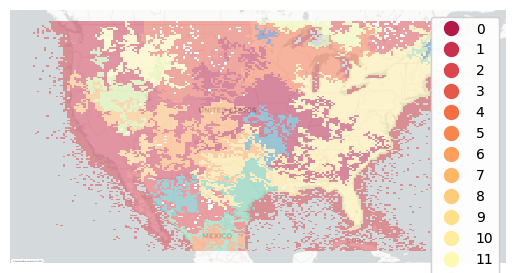

In [88]:
from src.geojson import build_geojson_feature_collection, write_geojson
from src.render import plot_clusters

feature_collection = build_geojson_feature_collection(
    geohash_cluster_dataframe,
    cluster_colors_dataframe,
)

# print_results(darwin_core_aggregations, all_stats, cluster_dataframe)

write_geojson(feature_collection, output_file)

plot_clusters(feature_collection)

write_geojson(feature_collection, output_file)

# TMP END

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=42,
    metric="precomputed",
    init="random",
    perplexity=min(30, distance_matrix.squareform().shape[0] - 1), # HACK FOR SMALLER DATASETS
)
X_tsne = tsne.fit_transform(distance_matrix.squareform())
tsne.kl_divergence_


2.4666571617126465

<Axes: >

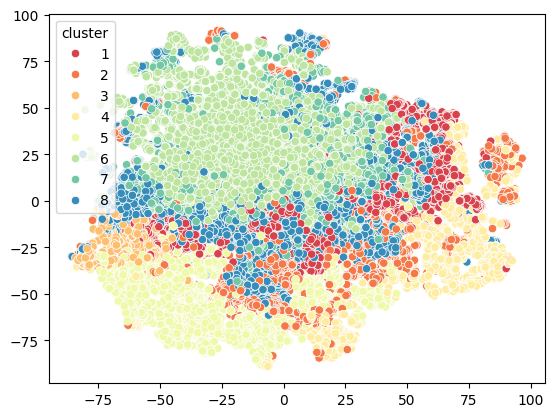

In [22]:
import seaborn as sns

sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=geohash_cluster_dataframe.df["cluster"],
    palette=cluster_colors_dataframe.to_dict(),
    alpha=1,
)

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
from scipy.cluster.hierarchy import linkage

from src.darwin_core import TaxonRank

linkage_array = linkage(distance_matrix.condensed(), "ward")

ordered_geohashes = geohash_taxa_counts_dataframe.ordered_geohashes()

def min_max_normalize(series: pl.Series) -> pl.Series:
    return (series - series.min()) / (series.max() - series.min())

col_colors = []
for geohash in ordered_geohashes:
    cluster = geohash_cluster_dataframe.cluster_for_geohash(geohash)
    col_colors.append(cluster_colors_dataframe.get_color_for_cluster(cluster))

data = {}
for species in cluster_significant_differences_dataframe.df["taxon"].unique():
    counts = []

    for geohash in ordered_geohashes:
        geohash_counts_species = geohash_taxa_counts_dataframe.df.filter(
            pl.col("geohash") == geohash, pl.col("name") == species
        ).get_column("count").sum()
        geohash_counts_all = geohash_taxa_counts_dataframe.df.filter(
            pl.col("geohash") == geohash
        ).get_column("count").sum()
        geohash_average = geohash_counts_species / geohash_counts_all
        all_average = (
            cluster_taxa_statistics_dataframe.df.filter(
                # pl.col("kingdom") == kingdom, FIXME
                pl.col("name") == species,
                pl.col("cluster").is_null(),
                pl.col("rank") == TaxonRank.species,
            )
            .get_column("average")
            .item()
        )
        counts.append(geohash_average - all_average)
    counts = pl.Series(
        values=counts,
        name=species,
    )
    # counts = counts / counts.max()
    # counts = counts.pow(1 / 3)
    data[species] = min_max_normalize(counts)


KeyboardInterrupt: 

In [ ]:
data

In [ ]:
dataframe = pl.DataFrame(data=data)
sns.clustermap(
    data=dataframe,
    col_cluster=False,
    row_cluster=True,
    row_linkage=linkage_array,
    row_colors=col_colors,
    xticklabels=dataframe.columns,
    yticklabels=False,
)